In [40]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plot
from scipy.stats import poisson
from scipy.stats import gamma
from scipy.stats import beta
from scipy.stats import norm
import pandas as pd
import itertools
from scipy.stats import dirichlet

In [55]:
def EstimateParameters(fixture_list_1, fixture_list_2, fixture_list_3,
                       teams, beta, thetapriormeans, thetapriorsds,
                       niter=1000, log=False, temp=0):
    
    # xdata and ydata are coordinates and y values of data
    # xmodel are coordinates of model evaluations
    # thetaprior are prior guesses for parameters
    
    # draw initial
    if log:
        if hasattr(thetapriormeans, '__len__'):
            theta = np.zeros(len(thetapriormeans))
            for i in range(len(thetapriormeans)):
                theta[i] = np.exp(np.random.normal(thetapriormeans[i], thetapriorsds[i], 1))
        else:
            theta = np.exp(np.random.normal(thetapriormeans, thetapriorsds, 1))
    else:
        if hasattr(thetapriormeans, '__len__'):
            theta = np.zeros(len(thetapriormeans))
            for i in range(len(thetapriormeans)):
                theta[i] = np.random.normal(thetapriormeans[i], thetapriorsds[i], 1)
            # normalize
            #theta[(len(teams) + 1 - 1)] = -np.sum(theta[1:(len(teams) + 1 - 1)])
            #theta[((2 * len(teams)) + 1 - 1)] = -np.sum(theta[(len(teams) + 1):((2 * len(teams)) + 1 - 1)])
        else:
            theta = np.random.normal(thetapriormeans, thetapriorsds, 1)
    
    if hasattr(thetapriormeans, '__len__'):
        thetaarray = np.zeros((niter, len(thetapriormeans)))
    else:
        thetaarray = np.zeros(niter)
    
    for j in range(niter):
        
        # temperature
        T = np.exp(-temp * ((i + 1) / niter))
        
        if log:
            if hasattr(thetapriormeans, '__len__'):
                thetastar = np.exp(np.log(theta) + np.random.normal(0, np.sqrt(beta), len(theta)))
            else:
                thetastar = np.exp(np.log(theta) + np.random.normal(0, np.sqrt(beta), 1))
        else:
            if hasattr(thetapriormeans, '__len__'):
                ind = np.random.normal(0, np.sqrt(beta), len(theta))
                # normalize
                #ind[(len(teams) + 1 - 1)] = -np.sum(ind[1:(len(teams) + 1 - 1)])
                #ind[((2 * len(teams)) + 1 - 1)] = -np.sum(ind[(len(teams) + 1):((2 * len(teams)) + 1 - 1)])
                thetastar = theta + ind
            else:
                ind = np.random.normal(0, np.sqrt(beta), 1)
                thetastar = theta + ind
        
        # get likelihood for each
        mu = theta[0]
        a = theta[1:(len(teams) + 1)]
        d = theta[(len(teams) + 1):((2 * len(teams)) + 1)]
        alpha = theta[((2 * len(teams)) + 1)]
        Htheta = likelihood_three_seasons(fixture_list_1, fixture_list_2, fixture_list_3,
                                          teams, mu, a, d, alpha)
        
        mu = thetastar[0]
        a = thetastar[1:(len(teams) + 1)]
        d = thetastar[(len(teams) + 1):((2 * len(teams)) + 1)]
        alpha = thetastar[((2 * len(teams)) + 1)]
        Hthetastar = likelihood_three_seasons(fixture_list_1, fixture_list_2, fixture_list_3,
                                              teams, mu, a, d, alpha)
        
        alpha = np.min([0, (1 / T) * (Hthetastar - Htheta)])
        
        # sample uniformly
        u = np.random.uniform(0, 1)
        
        # accept or not
        accept = np.log(u) <= alpha
        
        if accept:
            theta = thetastar
            
        if hasattr(thetapriormeans, '__len__'):
            thetaarray[j, :] = theta
            if (j%10) == 0:
                print('------')
                print('Iteration: ', str(j))
                print('Home coefficient: '+str(thetaarray[j, 0]))
                print('Arsenal attack coefficient: '+str(thetaarray[j, 1]))
        else:
            thetaarray[j] = theta
    
    return thetaarray

# create likelihood eval for one game
def likelihood_one_game(goals_ht, goals_at, form_ht, form_at, mu, a_ht, d_ht, a_at, d_at, alpha):
    lambda_ht = np.exp(mu + a_ht + d_at + (alpha * form_ht))
    lambda_at = np.exp(a_at + d_ht + (alpha * form_at))
    p1 = poisson.pmf(goals_ht, lambda_ht)
    p2 = poisson.pmf(goals_at, lambda_at)
    return(p1 * p2)

# create likelihood eval for single season
def likelihood_season(fixtures_list, teams, mu, a, d, alpha):
    N = np.shape(fixtures_list)[0]
    goals_ht = fixtures_list[:, 2]
    goals_at = fixtures_list[:, 3]
    teams_ht = fixtures_list[:, 0]
    teams_at = fixtures_list[:, 1]
    
    teams_for_season = np.unique(teams_ht)
    
    points = np.zeros((38, 20))
    team_count = np.zeros(20)
    for i in range(N):
        points[team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)].astype(int), np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] = (3 * (goals_ht[i] > goals_at[i])) + (goals_ht[i] == goals_at[i])
        points[team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)].astype(int), np.where(teams_for_season == teams_at[i])[0][0].astype(int)] = (3 * (goals_ht[i] < goals_at[i])) + (goals_ht[i] == goals_at[i])
        team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] += 1
        team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)] += 1
    form = np.ones((38, 20)) * 7.5
    for j in range(20):
        form[5:, j] = np.cumsum(points[:, j])[5:] - np.cumsum(points[:, j])[:(38 - 5)]
    
    team_count = np.zeros(20)
    likelihood = np.zeros(N)
    for i in range(N):
        ind_ht = np.where(teams == teams_ht[i])[0][0].astype(int)
        ind_at = np.where(teams == teams_at[i])[0][0].astype(int)
        ind_for_season_ht = np.where(teams_for_season == teams_ht[i])[0][0].astype(int)
        ind_for_season_at = np.where(teams_for_season == teams_at[i])[0][0].astype(int)
        l = likelihood_one_game(goals_ht[i], goals_at[i],
                                form[team_count[ind_for_season_ht].astype(int), ind_for_season_ht].astype(int), form[team_count[ind_for_season_at].astype(int), ind_for_season_at],
                                mu, a[ind_ht], d[ind_ht], a[ind_at], d[ind_at], alpha)
        team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] += 1
        team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)] += 1
        likelihood[i] = l
    
    return(np.sum(np.log(likelihood)))

# likelihood over three seasons - weighted
def likelihood_three_seasons(fixture_list_1, fixture_list_2, fixture_list_3, teams, mu, a, d, alpha):
    likelihood = (0.2 * likelihood_season(fixture_list_1, teams, mu, a, d, alpha)) + (0.3 * likelihood_season(fixture_list_2, teams, mu, a, d, alpha)) + (0.5 * likelihood_season(fixture_list_3, teams, mu, a, d, alpha))
    return(likelihood)

# function to predict probabilities of fixtures
def predict_fixtures(new_fixtures, form, teams, mu, a, d, alpha, uncertainty=False):
    if uncertainty:
        # form is N x 2
        N = np.shape(new_fixtures)[0]
        teams_ht = new_fixtures[:, 0]
        teams_at = new_fixtures[:, 1]
        lambda_1 = np.zeros(N)
        lambda_2 = np.zeros(N)
        for i in range(N):
            muest = np.random.normal(mu[0], mu[1])
            aest = np.zeros(len(teams))
            dest = np.zeros(len(teams))
            for u in range(len(teams)):
                aest[u] = np.random.normal(a[u, 0], a[u, 1])
                dest[u] = np.random.normal(d[u, 0], d[u, 1])
            alphaest = np.random.normal(alpha[0], alpha[1])
            ind_ht = np.where(teams == teams_ht[i])[0][0].astype(int)
            ind_at = np.where(teams == teams_at[i])[0][0].astype(int)
            lambda_1[i] = np.exp(muest + aest[ind_ht] + dest[ind_at] + (alphaest * form[i, 0]))
            lambda_2[i] = np.exp(aest[ind_at] + dest[ind_ht] + (alphaest * form[i, 1]))
    else:
        # form is N x 2
        N = np.shape(new_fixtures)[0]
        teams_ht = new_fixtures[:, 0]
        teams_at = new_fixtures[:, 1]
        lambda_1 = np.zeros(N)
        lambda_2 = np.zeros(N)
        for i in range(N):
            ind_ht = np.where(teams == teams_ht[i])[0][0].astype(int)
            ind_at = np.where(teams == teams_at[i])[0][0].astype(int)
            lambda_1[i] = np.exp(mu + a[ind_ht] + d[ind_at] + (alpha * form[i, 0]))
            lambda_2[i] = np.exp(a[ind_at] + d[ind_ht] + (alpha * form[i, 1]))
    return(lambda_1, lambda_2)

def import_fixture_lists(filename_1, filename_2, filename_3):
    fixture_list_1 = pd.read_csv(filename_1, header=None)
    fixture_list_2 = pd.read_csv(filename_2, header=None)
    fixture_list_3 = pd.read_csv(filename_3, header=None)
    return(fixture_list_1, fixture_list_2, fixture_list_3)

### Optimization of players

#### Probability functions of points scoring

In [44]:
def sample_clean_sheet_for_team(lambda_2):
    return(np.random.poisson(lambda_2) == 0)

def sample_mins_played(a, b, a_games, b_games):
    return(np.random.choice([1, 0], 1, p=np.random.dirichlet([a_games, b_games]))[0] * np.min([np.random.poisson(np.random.gamma(a, 1 / b)), 90]))

def sample_goals_and_assists(a, b, c, n, mins_played):
    t_goals = np.random.uniform(0, 90, n)  # times of goals
    n_goals = np.sum(t_goals <= mins_played)
    d = np.random.dirichlet(np.array([a, b, c]))  # sample hyperparameters
    if (n_goals > 0):
        samples = np.random.choice(np.array([0, 1, 2]), n_goals, p=d)
        return(sum(samples == 0), sum(samples == 1))
    else:
        return(0, 0)

def sample_clean_sheet_points(lambda_2, mins_played):
    return(int(mins_played > 60) * sample_clean_sheet_for_team(lambda_2))

def sample_mins_points(mins_played):
    return(int(mins_played > 60) + int(mins_played >= 1))

In [45]:
def ComputeExpectedPoints(fixtures_list, form, teams, all_players_params, all_teams_params,
                          zerooutbottom=0, Niter=250):
    
    # param data sets are pd Data Frames
    
    # Without bonus for now and goals conceded points
    
    # preallocate points for each iteration
    points = np.zeros((Niter, len(all_players_params.index)))

    # mean and std of team hyperparameters
    mu = (all_teams_params.as_matrix())[0, :]
    a = (all_teams_params.as_matrix())[1:(len(teams) + 1), :]
    d = (all_teams_params.as_matrix())[(len(teams) + 1):((2 * len(teams)) + 1), :]
    alpha = (all_teams_params.as_matrix())[((2 * len(teams)) + 1), :]

    for l in range(Niter):

        # sample lambdas for team performance - sample from team hyperparameters
        lambdas = predict_fixtures(fixtures_list, form, teams, mu, a, d, alpha, uncertainty=True)

        for i in range(len(all_players_params.index)):  # sample performance of teams from poisson model, and players also 
            h_games = np.where(fixtures_list[:, 0] == all_players_params.loc[all_players_params.index[i], 'team'])[0]
            a_games = np.where(fixtures_list[:, 1] == all_players_params.loc[all_players_params.index[i], 'team'])[0]
            if (len(h_games) > 0 or len(a_games) > 0):  # players in championship wont get any points this season!
                if all_players_params.loc[all_players_params.index[i], 'position'] == "GKP":
                    scaling = np.array([6., 3., 4.])
                if all_players_params.loc[all_players_params.index[i], 'position'] == "DEF":
                    scaling = np.array([6., 3., 4.])
                if all_players_params.loc[all_players_params.index[i], 'position'] == "MID":
                    scaling = np.array([5., 3., 1.])
                if all_players_params.loc[all_players_params.index[i], 'position'] == "FWD":
                    scaling = np.array([4., 3., 0.])
                for k in range(len(h_games)):  # over all home games
                    mins_played = sample_mins_played(all_players_params.loc[all_players_params.index[i], 'a_mins'], all_players_params.loc[all_players_params.index[i], 'b_mins'], all_players_params.loc[all_players_params.index[i], 'a_games'], all_players_params.loc[all_players_params.index[i], 'b_games'])  # sample mins played
                    n = np.random.poisson(lambdas[0][h_games[k]])  # sample total goal number
                    goa, assi = sample_goals_and_assists(all_players_params.loc[all_players_params.index[i], 'a_goals'],
                                                         all_players_params.loc[all_players_params.index[i], 'b_goals'],
                                                         all_players_params.loc[all_players_params.index[i], 'c_goals'],
                                                         n, mins_played)
                    points[l, i] += ((goa * scaling[0]) + (assi * scaling[1]))  # goals and assists
                    points[l, i] += ((scaling[2] * sample_clean_sheet_points(lambdas[1][h_games[k]], mins_played)) +
                                           (sample_mins_points(mins_played)))
                for k in range(len(a_games)):  # over all away games
                    mins_played = sample_mins_played(all_players_params.loc[all_players_params.index[i], 'a_mins'], all_players_params.loc[all_players_params.index[i], 'b_mins'], all_players_params.loc[all_players_params.index[i], 'a_games'], all_players_params.loc[all_players_params.index[i], 'b_games'])  # sample mins played
                    n = np.random.poisson(lambdas[1][a_games[k]])  # sample total goal number
                    goa, assi = sample_goals_and_assists(all_players_params.loc[all_players_params.index[i], 'a_goals'],
                                                         all_players_params.loc[all_players_params.index[i], 'b_goals'],
                                                         all_players_params.loc[all_players_params.index[i], 'c_goals'],
                                                         n, mins_played)
                    points[l, i] += ((goa * scaling[0]) + (assi * scaling[1]))  # goals and assists
                    points[l, i] += ((scaling[2] * sample_clean_sheet_points(lambdas[0][a_games[k]], mins_played)) +
                                           (sample_mins_points(mins_played)))

        print('---')
        print('Realisation ', l)
        print('Top Points Scorers: ', all_players_params.loc[all_players_params.index[np.argsort(points[l, :])[-5:].astype(int)], 'player'],
              ' with ', np.sort(points[l, :])[-5:], ' points')

    if zerooutbottom > 0:
        for l in range(Niter):
            points[l, np.argsort(points[l, :])[:zerooutbottom]] = 0  # to account for bench players when simulating team performance

    expected_points = np.mean(points, axis=0)
    sd_points = np.std(points, axis=0)

    return(expected_points, sd_points)

### Historical fitting

In [56]:
form = np.ones((380, 2)) * 5

all_players_params = pd.read_csv("../parameters/all_players_params.csv")
all_teams_params = pd.read_csv("../parameters/all_teams_params.csv", header=None)
teams = pd.read_csv("../parameters/all_teams.csv", header=None).values[:, 0]

In [57]:
# create fixture list this season to predict
fixture_list_this_season = []
for i, fix in enumerate(list(itertools.permutations(((pd.read_csv("../data/team_id_20192020.csv", header=1)).as_matrix())[:, 0], 2))):
    fixture_list_this_season.append(list(fix))
fixture_list_this_season = np.array(fixture_list_this_season)

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
# small fixture list - use for optimization for any particular gameweek
#fixture_list_this_season = (pd.read_csv("prem_results_20182019.csv", header=None).as_matrix())[:10, :]
#print(fixture_list_this_season)

#type in current form here
#form=....

In [59]:
C, S = ComputeExpectedPoints(fixture_list_this_season, form, teams, all_players_params, all_teams_params)

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


---
Realisation  0
Top Points Scorers:  134        Eden Hazard
341        Kyle Walker
329    Raheem Sterling
306         Sadio Mané
310      Mohamed Salah
Name: player, dtype: object  with  [154. 159. 167. 177. 184.]  points
---
Realisation  1
Top Points Scorers:  316             Andrew Robertson
322    Ederson Santana de Moraes
315              Virgil van Dijk
310                Mohamed Salah
134                  Eden Hazard
Name: player, dtype: object  with  [155. 158. 161. 161. 175.]  points
---
Realisation  2
Top Points Scorers:  128    César Azpilicueta
43            Nathan Aké
316     Andrew Robertson
130        Marcos Alonso
310        Mohamed Salah
Name: player, dtype: object  with  [153. 156. 160. 196. 215.]  points
---
Realisation  3
Top Points Scorers:  772    Alisson Ramses Becker
329          Raheem Sterling
128        César Azpilicueta
828             Matt Doherty
310            Mohamed Salah
Name: player, dtype: object  with  [147. 153. 155. 162. 166.]  points
---
Realis

---
Realisation  33
Top Points Scorers:  329          Raheem Sterling
772    Alisson Ramses Becker
128        César Azpilicueta
341              Kyle Walker
310            Mohamed Salah
Name: player, dtype: object  with  [151. 156. 157. 169. 207.]  points
---
Realisation  34
Top Points Scorers:  276            Jamie Vardy
175       Luka Milivojevic
306             Sadio Mané
167    Patrick van Aanholt
310          Mohamed Salah
Name: player, dtype: object  with  [154. 157. 160. 180. 207.]  points
---
Realisation  35
Top Points Scorers:  341          Kyle Walker
329      Raheem Sterling
128    César Azpilicueta
828         Matt Doherty
310        Mohamed Salah
Name: player, dtype: object  with  [150. 152. 155. 167. 221.]  points
---
Realisation  36
Top Points Scorers:  826           Willy Boly
128    César Azpilicueta
175     Luka Milivojevic
66            Lewis Dunk
310        Mohamed Salah
Name: player, dtype: object  with  [145. 151. 159. 161. 215.]  points
---
Realisation  37
Top Po

---
Realisation  66
Top Points Scorers:  128            César Azpilicueta
322    Ederson Santana de Moraes
130                Marcos Alonso
329              Raheem Sterling
310                Mohamed Salah
Name: player, dtype: object  with  [159. 163. 168. 189. 191.]  points
---
Realisation  67
Top Points Scorers:  131    David Luiz Moreira Marinho
828                  Matt Doherty
128             César Azpilicueta
516             Christian Eriksen
310                 Mohamed Salah
Name: player, dtype: object  with  [145. 150. 168. 169. 237.]  points
---
Realisation  68
Top Points Scorers:  134        Eden Hazard
315    Virgil van Dijk
43          Nathan Aké
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [155. 156. 157. 164. 208.]  points
---
Realisation  69
Top Points Scorers:  134      Eden Hazard
67       Shane Duffy
306       Sadio Mané
828     Matt Doherty
310    Mohamed Salah
Name: player, dtype: object  with  [155. 161. 180. 181. 192.]  points
-

---
Realisation  99
Top Points Scorers:  516    Christian Eriksen
67           Shane Duffy
306           Sadio Mané
128    César Azpilicueta
310        Mohamed Salah
Name: player, dtype: object  with  [149. 150. 152. 163. 231.]  points
---
Realisation  100
Top Points Scorers:  196      Jordan Pickford
828         Matt Doherty
130        Marcos Alonso
516    Christian Eriksen
310        Mohamed Salah
Name: player, dtype: object  with  [145. 152. 157. 168. 218.]  points
---
Realisation  101
Top Points Scorers:  130      Marcos Alonso
348    Aymeric Laporte
329    Raheem Sterling
310      Mohamed Salah
134        Eden Hazard
Name: player, dtype: object  with  [146. 153. 157. 185. 187.]  points
---
Realisation  102
Top Points Scorers:  128            César Azpilicueta
322    Ederson Santana de Moraes
828                 Matt Doherty
306                   Sadio Mané
310                Mohamed Salah
Name: player, dtype: object  with  [143. 144. 153. 188. 201.]  points
---
Realisation  103
To

---
Realisation  132
Top Points Scorers:  322    Ederson Santana de Moraes
828                 Matt Doherty
329              Raheem Sterling
306                   Sadio Mané
310                Mohamed Salah
Name: player, dtype: object  with  [146. 146. 153. 166. 174.]  points
---
Realisation  133
Top Points Scorers:  322    Ederson Santana de Moraes
329              Raheem Sterling
516            Christian Eriksen
310                Mohamed Salah
128            César Azpilicueta
Name: player, dtype: object  with  [146. 152. 166. 172. 173.]  points
---
Realisation  134
Top Points Scorers:  329      Raheem Sterling
522           Harry Kane
134          Eden Hazard
128    César Azpilicueta
828         Matt Doherty
Name: player, dtype: object  with  [147. 149. 149. 150. 153.]  points
---
Realisation  135
Top Points Scorers:  828        Matt Doherty
316    Andrew Robertson
315     Virgil van Dijk
134         Eden Hazard
310       Mohamed Salah
Name: player, dtype: object  with  [143. 143. 1

---
Realisation  166
Top Points Scorers:  772    Alisson Ramses Becker
66                Lewis Dunk
840             Raúl Jiménez
310            Mohamed Salah
329          Raheem Sterling
Name: player, dtype: object  with  [156. 157. 167. 168. 168.]  points
---
Realisation  167
Top Points Scorers:  721          Lucas Digne
134          Eden Hazard
368         Ashley Young
128    César Azpilicueta
310        Mohamed Salah
Name: player, dtype: object  with  [148. 153. 154. 173. 201.]  points
---
Realisation  168
Top Points Scorers:  128        César Azpilicueta
772    Alisson Ramses Becker
306               Sadio Mané
341              Kyle Walker
310            Mohamed Salah
Name: player, dtype: object  with  [146. 150. 158. 167. 266.]  points
---
Realisation  169
Top Points Scorers:  341                  Kyle Walker
372                   Paul Pogba
128            César Azpilicueta
322    Ederson Santana de Moraes
310                Mohamed Salah
Name: player, dtype: object  with  [146. 1

---
Realisation  199
Top Points Scorers:  306                   Sadio Mané
322    Ederson Santana de Moraes
772        Alisson Ramses Becker
128            César Azpilicueta
310                Mohamed Salah
Name: player, dtype: object  with  [155. 158. 171. 173. 182.]  points
---
Realisation  200
Top Points Scorers:  828         Matt Doherty
128    César Azpilicueta
516    Christian Eriksen
310        Mohamed Salah
329      Raheem Sterling
Name: player, dtype: object  with  [151. 153. 160. 208. 210.]  points
---
Realisation  201
Top Points Scorers:  299    Trent Alexander-Arnold
316          Andrew Robertson
772     Alisson Ramses Becker
306                Sadio Mané
310             Mohamed Salah
Name: player, dtype: object  with  [155. 160. 166. 174. 232.]  points
---
Realisation  202
Top Points Scorers:  134        Eden Hazard
828       Matt Doherty
130      Marcos Alonso
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [156. 162. 163. 180. 187.]  poin

---
Realisation  232
Top Points Scorers:  775        David de Gea
310       Mohamed Salah
316    Andrew Robertson
130       Marcos Alonso
329     Raheem Sterling
Name: player, dtype: object  with  [149. 159. 161. 176. 203.]  points
---
Realisation  233
Top Points Scorers:  306                   Sadio Mané
310                Mohamed Salah
43                    Nathan Aké
322    Ederson Santana de Moraes
329              Raheem Sterling
Name: player, dtype: object  with  [145. 146. 156. 169. 169.]  points
---
Realisation  234
Top Points Scorers:  828                 Matt Doherty
322    Ederson Santana de Moraes
306                   Sadio Mané
134                  Eden Hazard
310                Mohamed Salah
Name: player, dtype: object  with  [149. 162. 170. 173. 185.]  points
---
Realisation  235
Top Points Scorers:  322    Ederson Santana de Moraes
352                 David De Gea
128            César Azpilicueta
329              Raheem Sterling
310                Mohamed Salah
Name: p

In [60]:
# add expected points and std to data frame
all_players_params['Expected Points 2019/2020'] = C
all_players_params['Std Points 2019/2020'] = S
all_players_params['Lower 95% Confidence Points 2019/2020'] = np.fmax(0, C - (2 * S))
all_players_params['Upper 95% Confidence Points 2019/2020'] = C + (2 * S)

In [61]:
# save to csv
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frameref = frame[['player', 'position', 'team', 'Expected Points 2019/2020',
                  'Std Points 2019/2020', 'Lower 95% Confidence Points 2019/2020',
                  'Upper 95% Confidence Points 2019/2020']]
frameref.to_csv("../data/pre_draft_expected_points_20192020.csv")

In [62]:
# extract best current players
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020
310,310,31.6,21.6,2543.5,0.8,10.6,33.6,42.7,3,Mohamed Salah,MID,Liverpool,186.908,24.670864,137.566272,236.249728
329,329,28.2,14.9,2205.2,4.2,13.6,30.2,47.4,3,Raheem Sterling,MID,Man City,153.716,22.637918,108.440163,198.991837
128,128,31.4,2.1,2745.0,1.0,5.8,33.4,58.8,3,César Azpilicueta,DEF,Chelsea,145.724,16.116818,113.490364,177.957636
134,134,30.2,12.6,2229.1,2.2,10.3,32.2,32.0,3,Eden Hazard,MID,Chelsea,141.752,19.315551,103.120899,180.383101
322,322,31.3,1.0,2713.5,1.1,1.5,33.3,125.9,3,Ederson Santana de Moraes,GKP,Man City,140.408,13.290054,113.827892,166.988108
306,306,28.2,15.0,2239.7,4.2,4.9,30.2,47.7,3,Sadio Mané,MID,Liverpool,139.460,20.318868,98.822264,180.097736
828,828,20.0,3.0,1615.5,1.0,4.5,22.0,32.5,3,Matt Doherty,DEF,Wolves,135.288,15.463928,104.360145,166.215855
772,772,20.5,1.0,1755.0,0.5,1.0,22.5,94.5,3,Alisson Ramses Becker,GKP,Liverpool,135.172,12.506575,110.158850,160.185150
315,315,27.8,3.0,2412.9,4.6,3.0,29.8,70.5,3,Virgil van Dijk,DEF,Liverpool,132.084,17.451789,97.180422,166.987578
516,516,29.6,8.3,2395.4,2.8,10.0,31.6,39.9,3,Christian Eriksen,MID,Tottenham,131.096,17.354849,96.386302,165.805698


In [63]:
# extract best current goalkeepers
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'GKP'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020
322,322,31.3,1.0,2713.5,1.1,1.5,33.3,125.9,3,Ederson Santana de Moraes,GKP,Man City,140.408,13.290054,113.827892,166.988108
772,772,20.5,1.0,1755.0,0.5,1.0,22.5,94.5,3,Alisson Ramses Becker,GKP,Liverpool,135.172,12.506575,110.158850,160.185150
710,710,19.5,1.0,1665.0,1.5,1.0,21.5,80.0,3,Kepa Arrizabalaga,GKP,Chelsea,121.984,13.479753,95.024494,148.943506
775,775,20.0,1.0,1755.0,1.0,1.0,22.0,82.5,3,David de Gea,GKP,Man United,120.424,13.167089,94.089823,146.758177
196,196,32.2,1.0,2781.0,0.2,1.0,34.2,90.7,3,Jordan Pickford,GKP,Everton,117.608,11.346468,94.915064,140.300936
506,506,28.3,1.0,2502.0,4.1,1.0,30.3,99.1,3,Hugo Lloris,GKP,Tottenham,116.488,12.988066,90.511868,142.464132
844,844,19.5,1.0,1710.0,1.5,1.0,21.5,72.5,3,Rui Pedro dos Santos Patrício,GKP,Wolves,113.240,13.419627,86.400745,140.079255
259,259,30.2,1.0,2644.5,2.2,1.0,32.2,87.8,3,Kasper Schmeichel,GKP,Leicester,105.776,12.083618,81.608764,129.943236
474,474,31.7,1.0,2781.0,0.7,1.0,33.7,85.1,3,Lukasz Fabianski,GKP,West Ham,105.100,11.259929,82.580142,127.619858
578,578,31.4,1.0,2754.0,1.0,1.0,33.4,85.4,3,Ben Foster,GKP,Watford,104.116,10.408388,83.299224,124.932776


In [64]:
# extract best current defenders
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'DEF'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020
128,128,31.4,2.1,2745.0,1.0,5.8,33.4,58.8,3,César Azpilicueta,DEF,Chelsea,145.724,16.116818,113.490364,177.957636
828,828,20.0,3.0,1615.5,1.0,4.5,22.0,32.5,3,Matt Doherty,DEF,Wolves,135.288,15.463928,104.360145,166.215855
315,315,27.8,3.0,2412.9,4.6,3.0,29.8,70.5,3,Virgil van Dijk,DEF,Liverpool,132.084,17.451789,97.180422,166.987578
130,130,26.4,4.1,2281.0,6.0,5.6,28.4,49.1,3,Marcos Alonso,DEF,Chelsea,130.644,17.967450,94.709100,166.578900
341,341,27.9,1.5,2268.2,4.5,3.3,29.9,80.2,3,Kyle Walker,DEF,Man City,130.216,17.581619,95.052761,165.379239
316,316,26.4,1.3,2235.0,6.0,8.5,28.4,63.9,3,Andrew Robertson,DEF,Liverpool,129.264,17.775329,93.713343,164.814657
826,826,19.5,3.0,1629.0,1.5,1.0,21.5,35.5,3,Willy Boly,DEF,Wolves,123.624,14.958430,93.707140,153.540860
833,833,20.0,1.0,1755.0,1.0,1.0,22.0,38.0,3,Conor Coady,DEF,Wolves,118.868,13.033287,92.801426,144.934574
721,721,19.0,3.0,1527.0,2.0,3.5,21.0,36.0,3,Lucas Digne,DEF,Everton,118.688,15.764728,87.158544,150.217456
43,43,31.4,3.6,2756.1,1.0,2.4,33.4,52.0,3,Nathan Aké,DEF,Bournemouth,118.376,14.934076,88.507848,148.244152


In [65]:
# extract best current midfielders
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'MID'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020
310,310,31.6,21.6,2543.5,0.8,10.6,33.6,42.7,3,Mohamed Salah,MID,Liverpool,186.908,24.670864,137.566272,236.249728
329,329,28.2,14.9,2205.2,4.2,13.6,30.2,47.4,3,Raheem Sterling,MID,Man City,153.716,22.637918,108.440163,198.991837
134,134,30.2,12.6,2229.1,2.2,10.3,32.2,32.0,3,Eden Hazard,MID,Chelsea,141.752,19.315551,103.120899,180.383101
306,306,28.2,15.0,2239.7,4.2,4.9,30.2,47.7,3,Sadio Mané,MID,Liverpool,139.460,20.318868,98.822264,180.097736
516,516,29.6,8.3,2395.4,2.8,10.0,31.6,39.9,3,Christian Eriksen,MID,Tottenham,131.096,17.354849,96.386302,165.805698
175,175,30.8,10.0,2678.7,1.6,2.6,32.8,31.0,3,Luka Milivojevic,MID,Crystal Palace,126.172,16.428220,93.315560,159.028440
372,372,27.4,9.3,2192.0,5.0,9.9,29.4,35.0,3,Paul Pogba,MID,Man United,124.000,17.194883,89.610234,158.389766
220,220,28.1,8.7,2283.1,4.3,5.2,30.1,28.6,3,Gylfi Sigurdsson,MID,Everton,118.688,16.468596,85.750808,151.625192
563,563,29.9,9.0,2221.1,2.5,4.9,31.9,30.2,3,Richarlison de Andrade,MID,Everton,114.740,16.193591,82.352817,147.127183
817,817,19.5,5.5,1567.5,1.5,4.0,21.5,22.5,3,Felipe Anderson Pereira Gomes,MID,West Ham,111.704,13.550217,84.603566,138.804434


In [66]:
# extract best current forwards
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'FWD'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020
522,522,26.6,18.2,2178.7,5.8,4.6,28.6,30.4,3,Harry Kane,FWD,Tottenham,124.920,18.287088,88.345823,161.494177
276,276,29.9,16.0,2382.4,2.5,4.1,31.9,24.7,3,Jamie Vardy,FWD,Leicester,124.160,15.808302,92.543397,155.776603
840,840,20.0,7.5,1601.0,1.0,6.0,22.0,16.5,3,Raúl Jiménez,FWD,Wolves,118.968,14.409406,90.149188,147.786812
339,339,25.0,17.8,1861.5,7.4,8.3,27.0,41.3,3,Sergio Agüero,FWD,Man City,112.560,18.840552,74.878896,150.241104
169,169,27.2,8.7,2328.2,5.2,8.6,29.2,22.4,3,Wilfried Zaha,FWD,Crystal Palace,110.968,14.839642,81.288716,140.647284
311,311,29.6,11.5,2176.0,2.8,7.4,31.6,51.5,3,Roberto Firmino,FWD,Liverpool,107.500,13.256923,80.986155,134.013845
592,592,28.3,8.6,2175.0,4.1,5.9,30.3,20.1,3,Salomón Rondón,FWD,Newcastle,100.744,13.830346,73.083308,128.404692
396,396,31.1,9.4,2248.8,1.3,3.8,33.1,25.7,3,Ayoze Pérez,FWD,Newcastle,97.840,11.721024,74.397952,121.282048
56,56,29.2,9.4,2261.5,3.2,3.7,31.2,32.7,3,Joshua King,FWD,Bournemouth,97.148,13.210227,70.727546,123.568454
53,53,25.2,10.4,1903.3,7.2,7.6,27.2,22.0,3,Callum Wilson,FWD,Bournemouth,95.448,15.044444,65.359112,125.536888


### Analysis

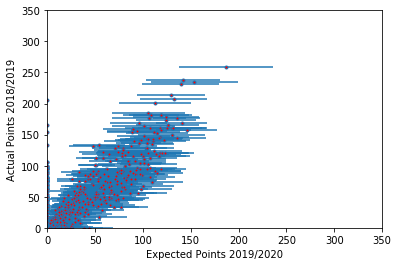

In [70]:
# plot with respect to last seasons points - for those players eligible
y3 = pd.read_csv("../data/players_raw_20182019.csv")
y3['full_name'] = (y3['first_name'] + ' ' + y3['second_name'])
exp_points = np.zeros(len(y3.index))
sd_points = np.zeros(len(y3.index))
for i in range(len(y3.index)):
    ind = np.where(y3.loc[y3.index[i], 'full_name'] == all_players_params['player'])[0][0]
    exp_points[i] = all_players_params.loc[all_players_params.index[ind], 'Expected Points 2019/2020']
    sd_points[i] = all_players_params.loc[all_players_params.index[ind], 'Std Points 2019/2020']

plot.errorbar(exp_points, y3['total_points'], xerr=2 * sd_points, marker='.', mfc='r', linestyle="")
plot.xlim([0, 350])
plot.ylim([0, 350])
plot.xlabel('Expected Points 2019/2020')
plot.ylabel('Actual Points 2018/2019')
plot.show()

### Team predictions

Gives predictions for a team's score on a gameweek

In [58]:
# this gameweek fixtures
#fixture_list_this_gw = (pd.read_csv("prem_results_20182019.csv", header=None).as_matrix())[:10, :]
#print(fixture_list_this_gw)

# this gameweek form for each fixture
#form =...

# players for a specific team
tm_players = ['Mohamed Salah', 'James Milner'] #....
new_players_frame = all_players_params[all_players_params['player'].isin(tm_players)]
Niter = 100
C, S = ComputeExpectedPoints(fixture_list_this_gw, form, teams, new_players_frame, all_teams_params,
                             zerooutbottom=3, Niter=Niter)  # zero out bench players
expected_tm_score = np.sum(C)
sd_tm_score = np.sqrt(np.sum(S ** 2))
print('expected team score: ', expected_tm_score)
print('lower 95% confidence team score: ', max(0, expected_tm_score - (2 * sd_tm_score)))
print('upper 95% confidence team score: ', expected_tm_score + (2 * sd_tm_score))

---
Realisation  0
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [0. 2.]  points
---
Realisation  1
Top Points Scorers:  310    Mohamed Salah
298     James Milner
Name: player, dtype: object  with  [2. 5.]  points
---
Realisation  2
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [1. 2.]  points
---
Realisation  3
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [ 4. 10.]  points
---
Realisation  4
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [2. 3.]  points
---
Realisation  5
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [0. 3.]  points
---
Realisation  6
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [1. 2.]  points
---
Realisation  7
Top Points Scorers:  298     James Milner
310   

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [ ]:
# calculates match probability
def match_prob(exp_p1, sd_p1, exp_p2, sd_p2):
    exp_diff = exp_p1 - exp_p2
    sd_diff = np.sqrt((sd_p1 ** 2) + (sd_p2 ** 2))
    return(1 - norm.cdf(0, exp_diff, sd_diff))